In [1]:
!pip3 install tensorflow-estimator==2.6.0

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time

In [3]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [4]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
  
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [5]:
def draw_bounding_box_on_image(image,
                              ymin, xmin, ymax, xmax,
                              color,
                              font,
                              thickness=4,
                              display_str_list=()):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                 ymin * im_height, ymax * im_height)
    
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
             width = thickness,
             fill=color)
    
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

In [6]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1): 
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmpnqdjxhyu.jpg.


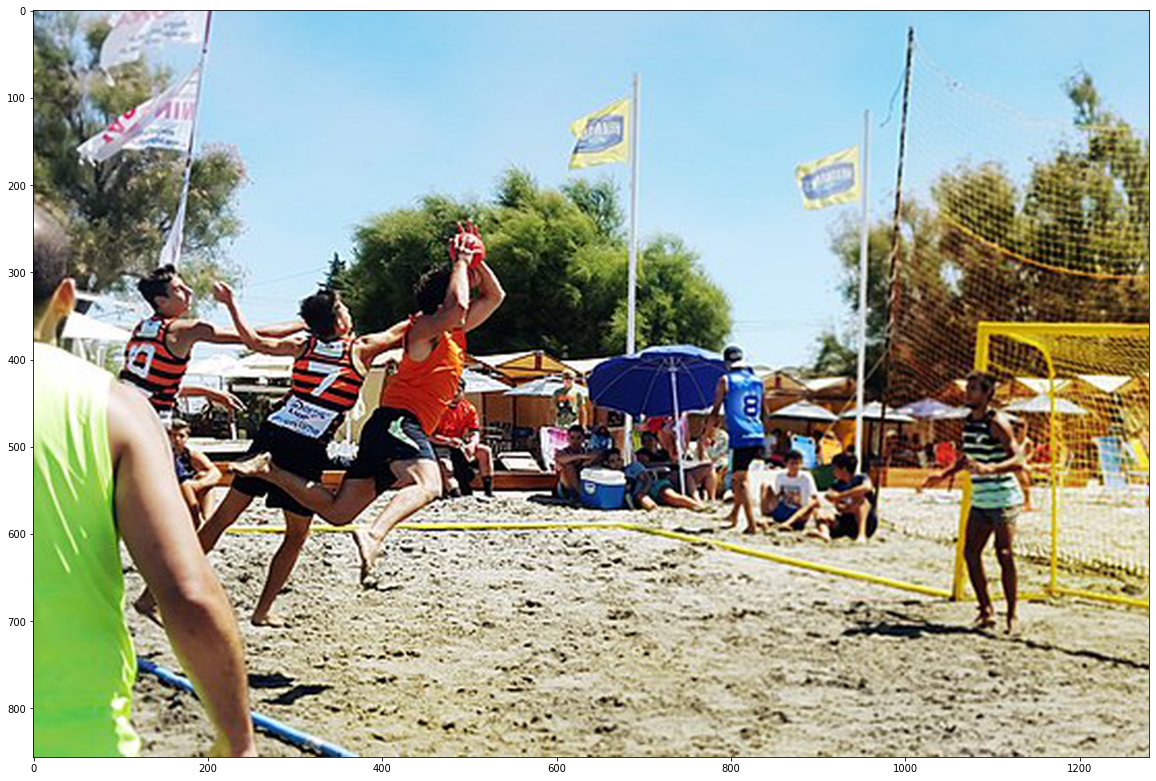

In [7]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [8]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [49]:
def run_detector(detector, path):
  img = load_img(path) 

  converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  44.8605101108551


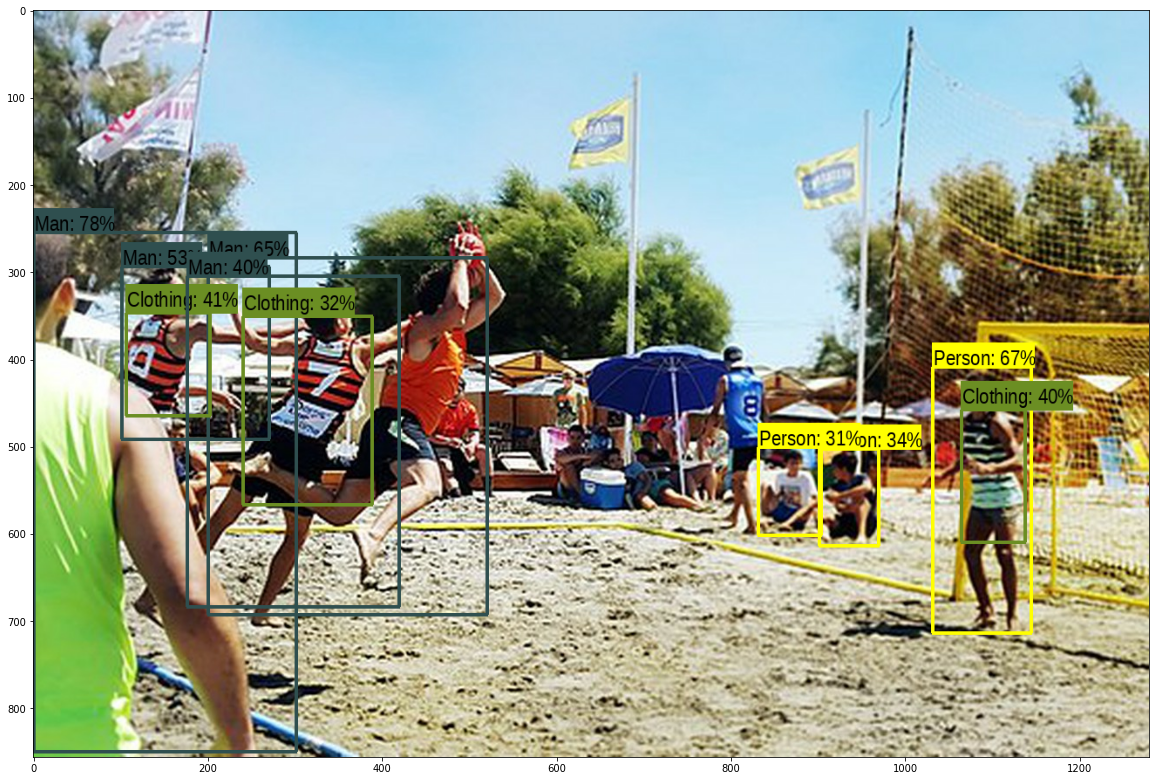

In [11]:
run_detector(detector, downloaded_image_path)

Image downloaded to /tmp/tmpyjlktw0k.jpg.


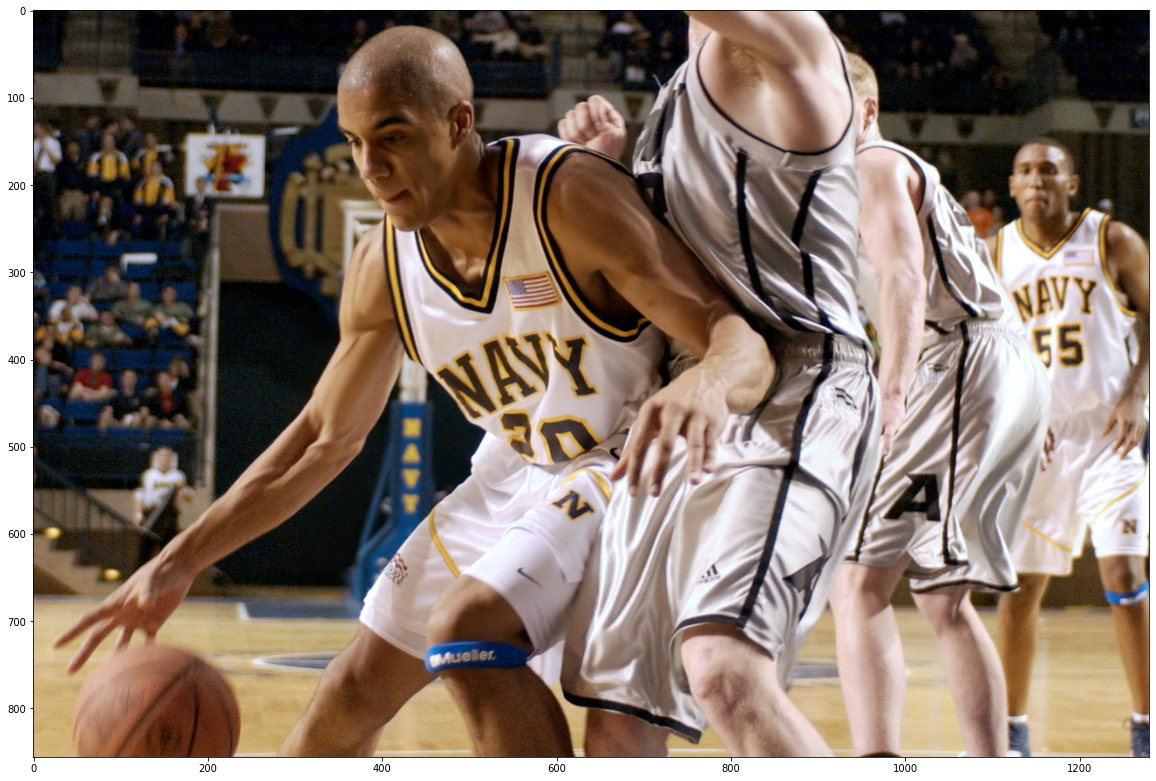

In [12]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/a/af/Basketball_game.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Found 100 objects.
Inference time:  1.4255757331848145


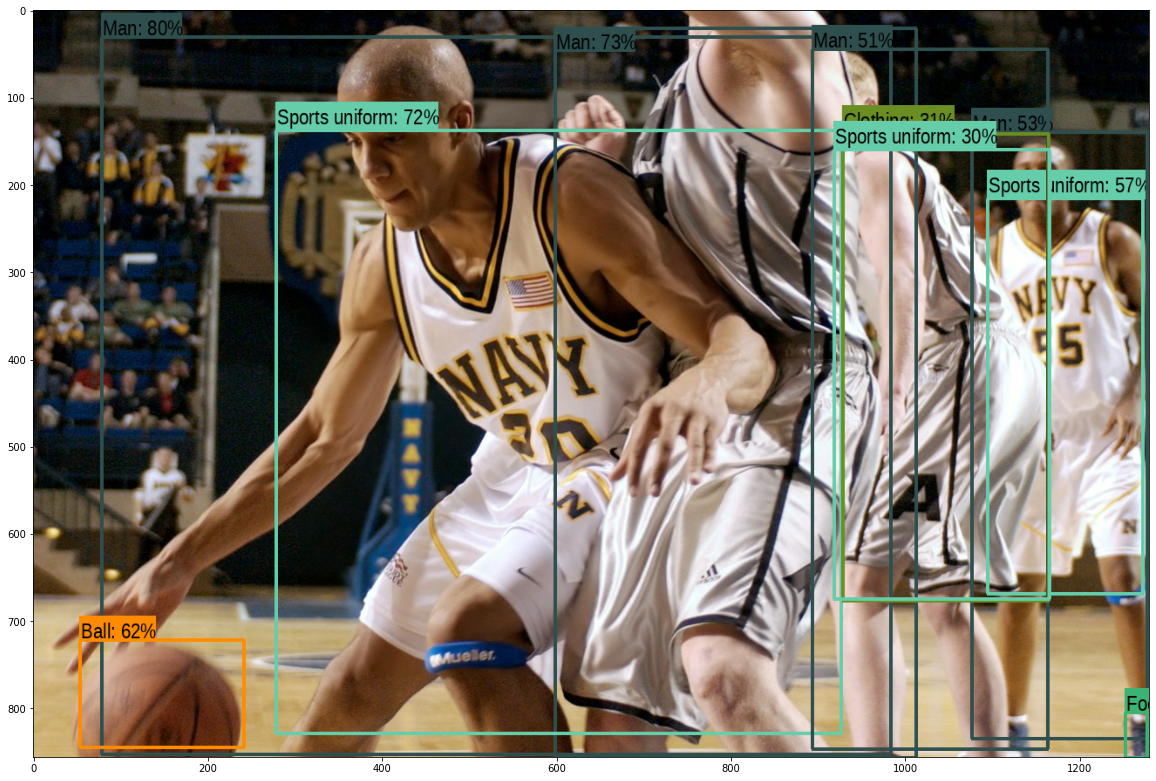

In [13]:
run_detector(detector, downloaded_image_path)

In [55]:
module_handle = "https://kaggle.com/models/tensorflow/centernet-hourglass/frameworks/TensorFlow2/variations/512x512/versions/1"

detector = hub.load(module_handle)

Image downloaded to /tmp/tmpu7r547lv.jpg.


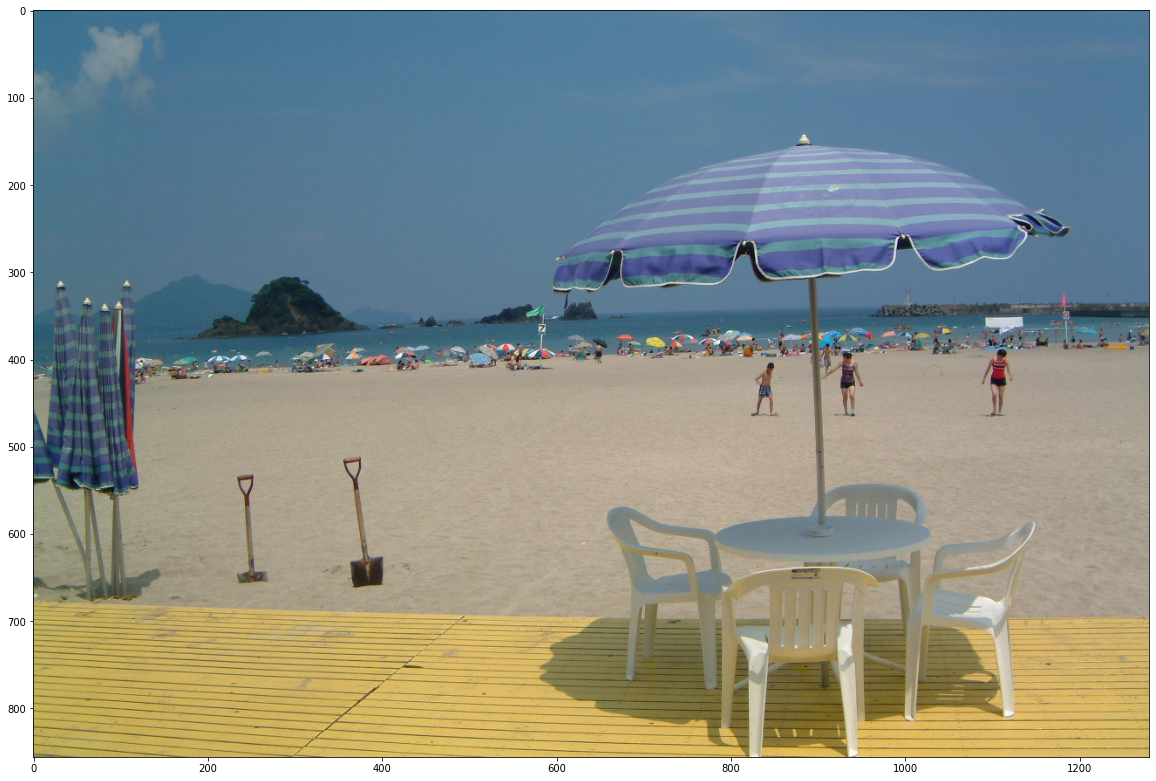

In [40]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/b/bb/Wada_beach_1.JPG"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [56]:
run_detector(detector, downloaded_image_path)

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[[0.22352943 0.44705886 0.5529412 ]
   [0.21960786 0.4431373  0.54901963]
   [0.21960786 0.4431373  0.54901963]
   ...
   [0.3019608  0.4784314  0.60784316]
   [0.30588236 0.48235297 0.6117647 ]
   [0.28627452 0.46274513 0.5921569 ]]

  [[0.22352943 0.44705886 0.5529412 ]
   [0.21960786 0.4431373  0.54901963]
   [0.21960786 0.4431373  0.54901963]
   ...
   [0.28627452 0.46274513 0.5921569 ]
   [0.29803923 0.47450984 0.6039216 ]
   [0.2901961  0.4666667  0.59607846]]

  [[0.22352943 0.44705886 0.5529412 ]
   [0.22352943 0.44705886 0.5529412 ]
   [0.22352943 0.44705886 0.5529412 ]
   ...
   [0.2901961  0.4666667  0.59607846]
   [0.3019608  0.4784314  0.60784316]
   [0.3019608  0.4784314  0.60784316]]

  ...

  [[0.62352943 0.60784316 0.36078432]
   [0.6117647  0.59607846 0.34509805]
   [0.58431375 0.5686275  0.31764707]
   ...
   [0.8235295  0.7137255  0.38431376]
   [0.8313726  0.72156864 0.39607847]
   [0.8196079  0.70980394 0.38431376]]

  [[0.6156863  0.6117647  0.38823533]
   [0.6039216  0.6        0.37647063]
   [0.58431375 0.5803922  0.35686275]
   ...
   [0.83921576 0.7372549  0.40784317]
   [0.85098046 0.7411765  0.4156863 ]
   [0.8431373  0.73333335 0.40784317]]

  [[0.5294118  0.5294118  0.31764707]
   [0.52156866 0.52156866 0.30980393]
   [0.52156866 0.5254902  0.3019608 ]
   ...
   [0.8313726  0.7294118  0.40000004]
   [0.8431373  0.73333335 0.40784317]
   [0.83921576 0.7294118  0.4039216 ]]]], shape=(1, 856, 1280, 3), dtype=float32))
  input_signature: (
    TensorSpec(shape=(1, None, None, 3), dtype=tf.uint8, name=None))